## Processing Digits and Symbols 

## Generate and save Dataset to Drive

Only needed once for data preparation

In [ ]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import struct
import torch

def load_train_images():
    path = '/content/drive/MyDrive/dlproject/'

    file = path + 'train-images.idx3-ubyte'
    images = idx2numpy.convert_from_file(file)
    # arr is now a np.ndarray type of object of shape 60000, 28, 28

    with open(path + 'train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = data.reshape((size,)) # (Optional)

    minuses = os.listdir(f'{path}dataset/minus-imgs/')
    img_minuses = []
    for p in minuses:
      img = image.imread(f'{path}dataset/minus-imgs/{p}')
      img_minuses.append(img)
      print(f'\r{p}', end='')

    pluses = os.listdir(f'{path}dataset/plus-imgs/')
    img_pluses = []
    for p in pluses:
      img = image.imread(f'{path}dataset/plus-imgs/{p}')
      img_pluses.append(img)
      print(f'\r{p}', end='')

    x = np.append(images, img_pluses + img_minuses, axis=0)
    y = np.append(labels, [10]*len(pluses) + [11]*len(minuses), axis=0)

    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=5f6cbb4dfc1c294aea62ccacb790ce40adbc137d0b1cad879da24b5d32fb4323
  Stored in directory: /root/.cache/pip/wheels/27/40/a8/6447ee4a00cb87e2084e1ef1df5c38433720cc1090be082842
Successfully built idx2numpy


In [ ]:
all_images, all_labels = load_train_images()

path = '/content/drive/MyDrive/dlproject/cnn/'
np.save(f"{path}all_images.npy", all_images)
np.save(f"{path}all_labels.npy" , all_labels)

+_999.jpg

# Load Dataset from Drive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/MyDrive/dlproject/cnn/'
all_images = np.load(f"{path}all_images.npy")
all_labels = np.load(f"{path}all_labels.npy")

2


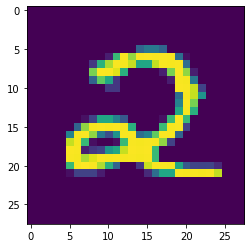

In [ ]:
rand = np.random.randint(0, all_labels.shape[0] -1)
plt.imshow(all_images[rand])
print(all_labels[rand])

In [ ]:
all_images[0].dtype

dtype('uint8')

## Pytorch Neural Networks

In [ ]:
#CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)
        return image.to(device), label

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = CustomImageDataset(all_labels[:-6000], all_images[:-6000], transform=ToTensor())
test_data = CustomImageDataset(all_labels[-6000:], all_images[-6000:], transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#DO NOT TOUCH THIS, PLEASE :)
class CNN(nn.Module):                  #Score: 99.2%
    def __init__(self, out_classes):
        super(CNN, self).__init__()

        # Layer #1
        self.conv1 = nn.Sequential(     #Input 28*28*1     
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                          #Output 24*24*32                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2) #Output 12*12*32
        )
        # Layer #2
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=0,
            ),                          #Output 10*10*64
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #Output 5*5*64              
        )
        self.dense = nn.Sequential(
            nn.Linear(5*5*64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, out_classes)
        )
    def forward(self, x):
        # Put through 2 convolution layers and a 3L deep network with dropouts
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  #Flatten
        output = self.dense(x)
        return output

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device=device):
    model = model.to(device)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
model = CNN(12)

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 26.127502  [    0/66000]
loss: 0.606561  [ 6400/66000]
loss: 0.253658  [12800/66000]
loss: 0.157520  [19200/66000]
loss: 0.070568  [25600/66000]
loss: 0.119009  [32000/66000]
loss: 0.174095  [38400/66000]
loss: 0.053145  [44800/66000]
loss: 0.082126  [51200/66000]
loss: 0.053039  [57600/66000]
loss: 0.081190  [64000/66000]
Test Error: 
 Accuracy: 33.8%, Avg loss: 2.464166 

Epoch 2
-------------------------------
loss: 0.023129  [    0/66000]
loss: 0.009421  [ 6400/66000]
loss: 0.122259  [12800/66000]
loss: 0.164396  [19200/66000]
loss: 0.046042  [25600/66000]
loss: 0.074932  [32000/66000]
loss: 0.118572  [38400/66000]
loss: 0.093792  [44800/66000]
loss: 0.033052  [51200/66000]
loss: 0.019812  [57600/66000]
loss: 0.368665  [64000/66000]
Test Error: 
 Accuracy: 43.4%, Avg loss: 2.462988 

Epoch 3
-------------------------------
loss: 0.014297  [    0/66000]
loss: 0.028656  [ 6400/66000]
loss: 0.109941  [12800/66000]
loss: 0.020866  [19200/66

In [ ]:
model = CNN(12)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters())

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.482983  [    0/66000]
loss: 0.496959  [ 6400/66000]
loss: 0.109924  [12800/66000]
loss: 0.168131  [19200/66000]
loss: 0.052683  [25600/66000]
loss: 0.083594  [32000/66000]
loss: 0.064932  [38400/66000]
loss: 0.102988  [44800/66000]
loss: 0.111047  [51200/66000]
loss: 0.104241  [57600/66000]
loss: 0.043891  [64000/66000]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.115548 

Epoch 2
-------------------------------
loss: 0.073566  [    0/66000]
loss: 0.122433  [ 6400/66000]
loss: 0.031152  [12800/66000]
loss: 0.112576  [19200/66000]
loss: 0.112249  [25600/66000]
loss: 0.310836  [32000/66000]
loss: 0.010829  [38400/66000]
loss: 0.048398  [44800/66000]
loss: 0.007542  [51200/66000]
loss: 0.246840  [57600/66000]
loss: 0.049951  [64000/66000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.066432 

Epoch 3
-------------------------------
loss: 0.165295  [    0/66000]
loss: 0.044631  [ 6400/66000]
loss: 0.046008  [12800/66000]
loss: 0.000198  [19200/660

In [ ]:
torch.save(model, '../resources/cnn.pth')